In [15]:
%config Completer.use_jedi = False
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn-metrics-confusionmatrixdisplay

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [16]:
# pip install imageio
# pip install plotly



In [17]:
#pip install --upgrade scikit-learn


In [18]:
# pip install tensorflow-addons

In [19]:
directory = r'The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

**# this code helps collect and organize statistics about image sizes within different categories, which could be useful for data analysis or preprocessing tasks.**

In [20]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

/var/folders/6r/w6lhlth93yn4c397t0sc0gpw0000gn/T/ipykernel_59944/1417439949.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 623': 31,
  '512 x 512': 501,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

**# This code snippet goes through each category, loads the first image it encounters in grayscale, displays it, and then moves on to the next category. It's a simple way to visualize the first image in each category.**

Bengin cases


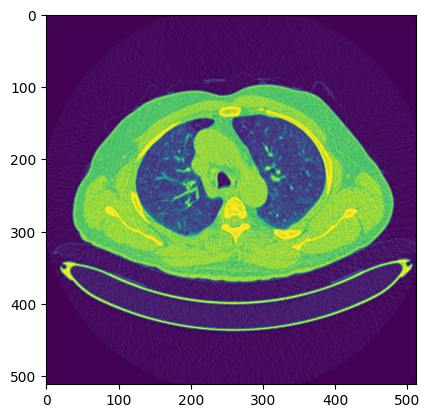

Malignant cases


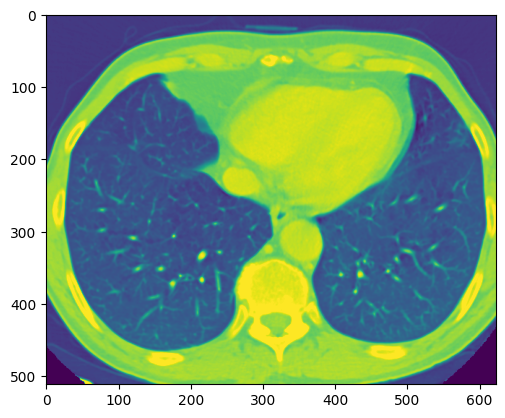

Normal cases


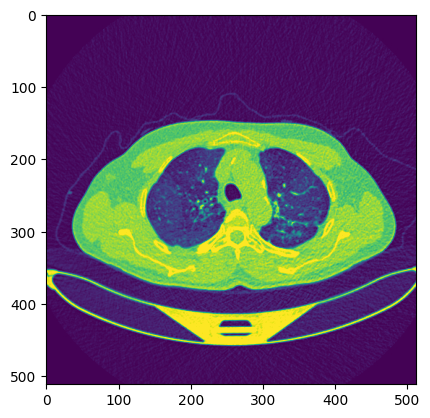

In [22]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

**The below code visualizes a subset of images from each category by displaying three versions of each image: the original, the resized version, and the version with Gaussian blur. This is done for a limited number of images (controlled by samples) within each category. If you take a photo in low light and the resulting image has a lot of noise, Gaussian blur can mute that noise.**

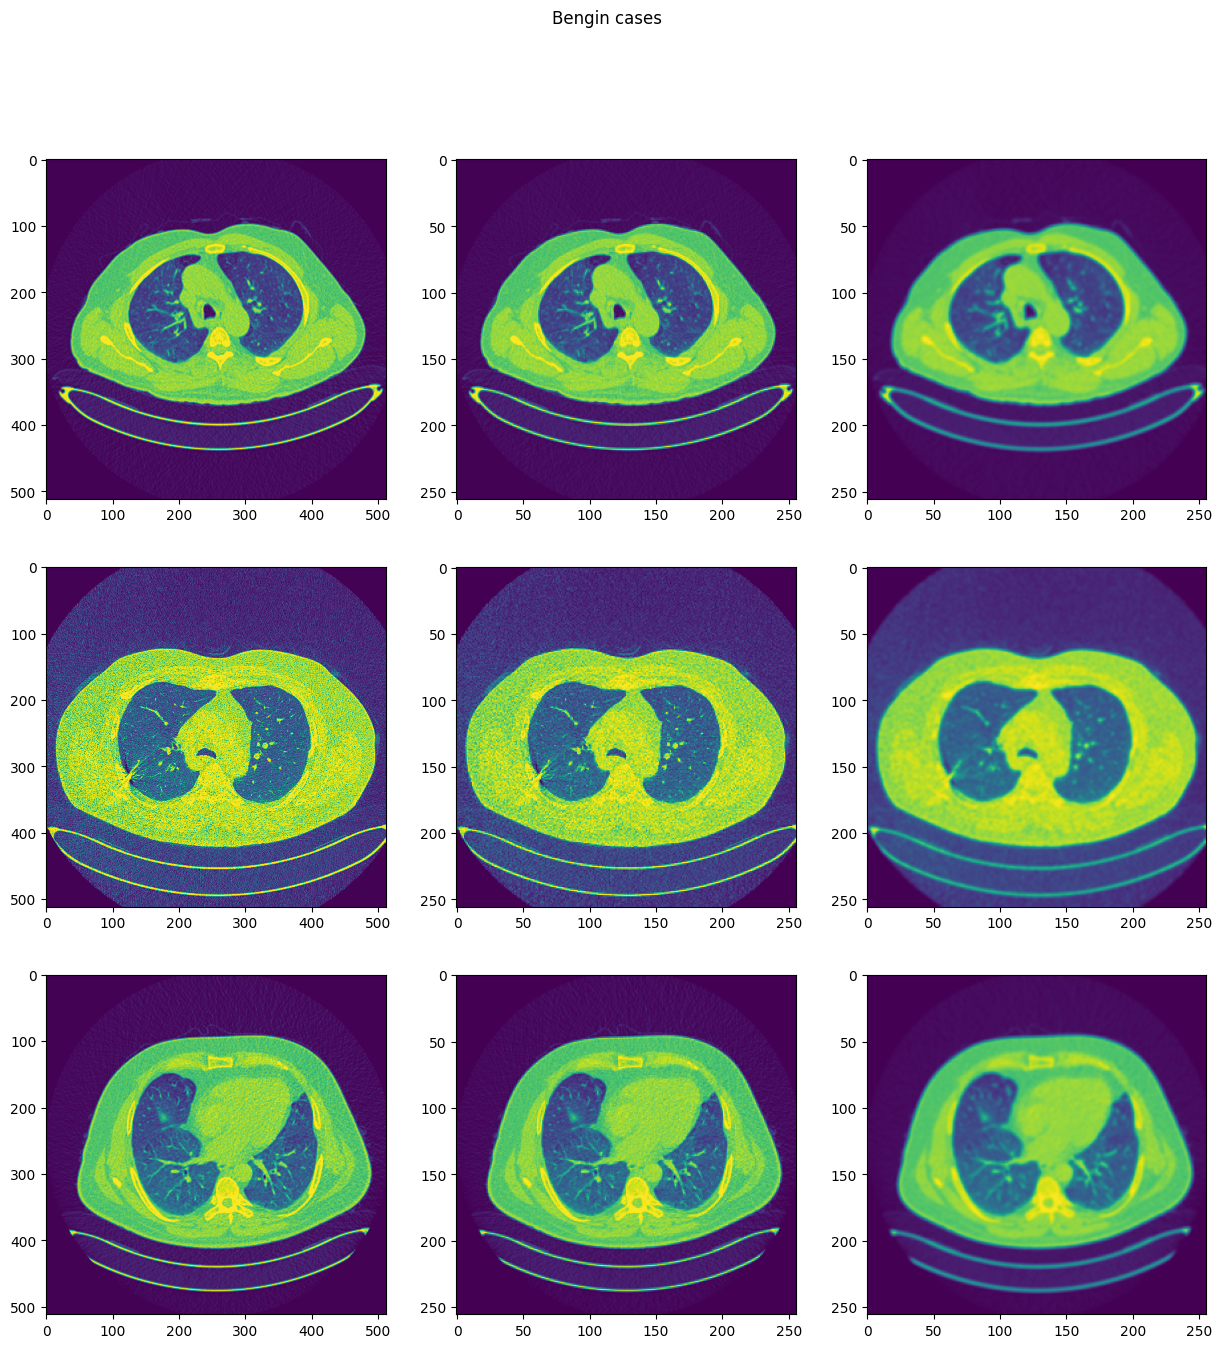

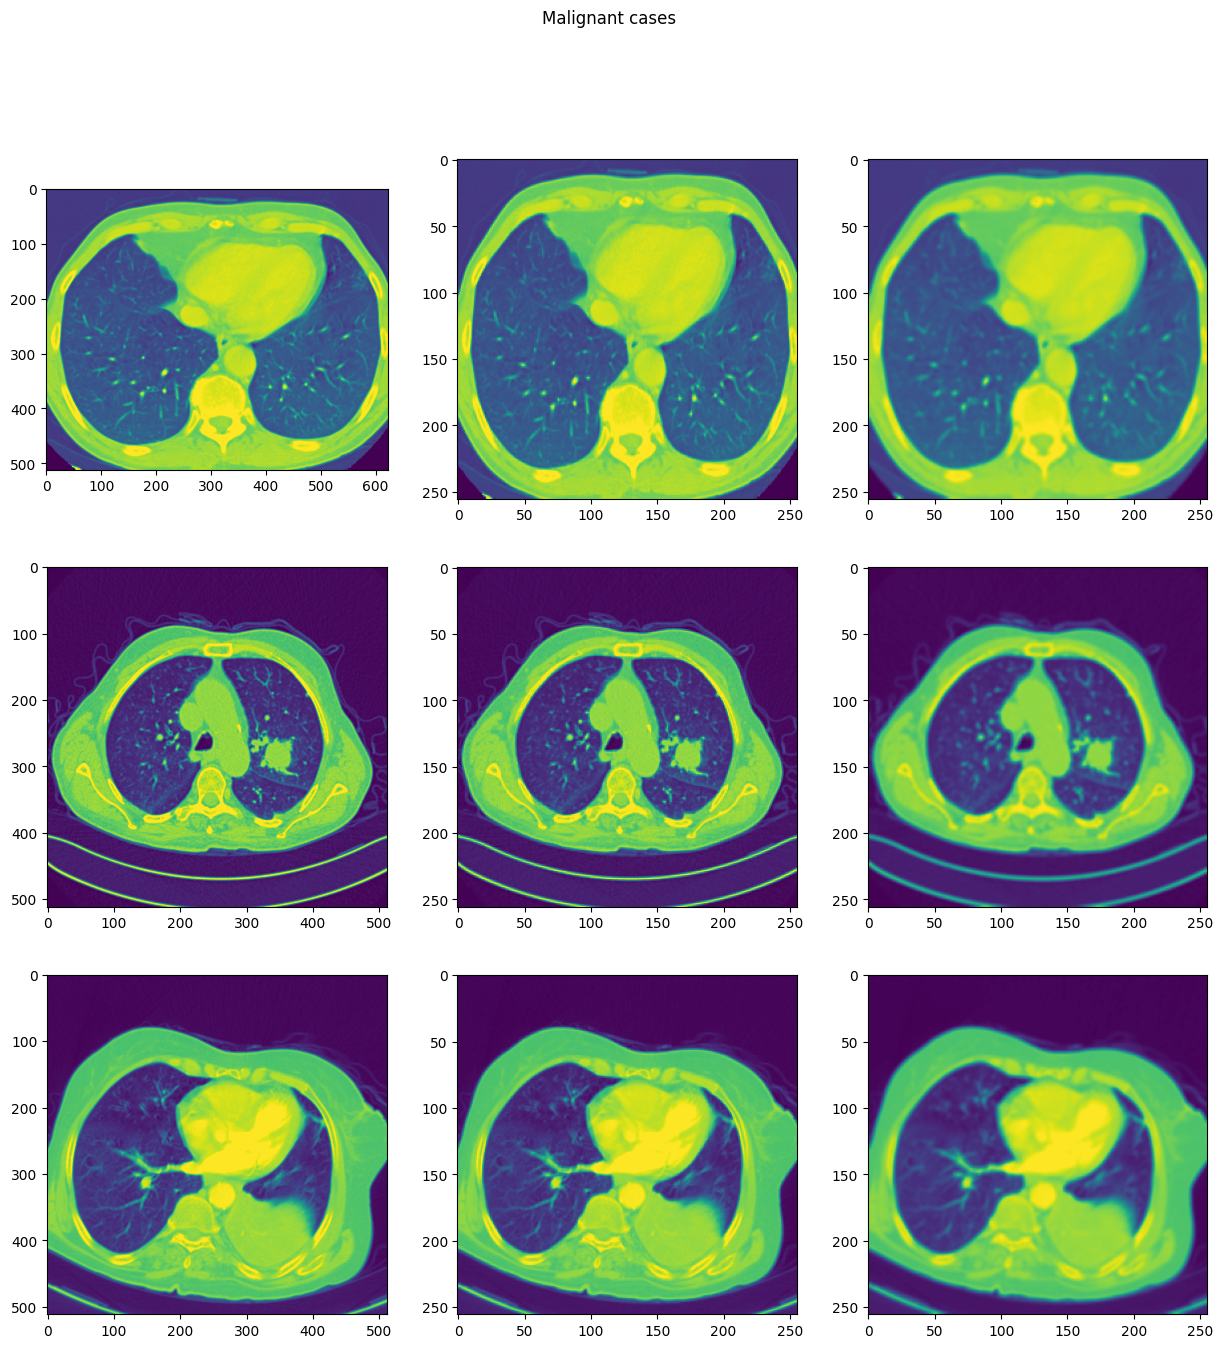

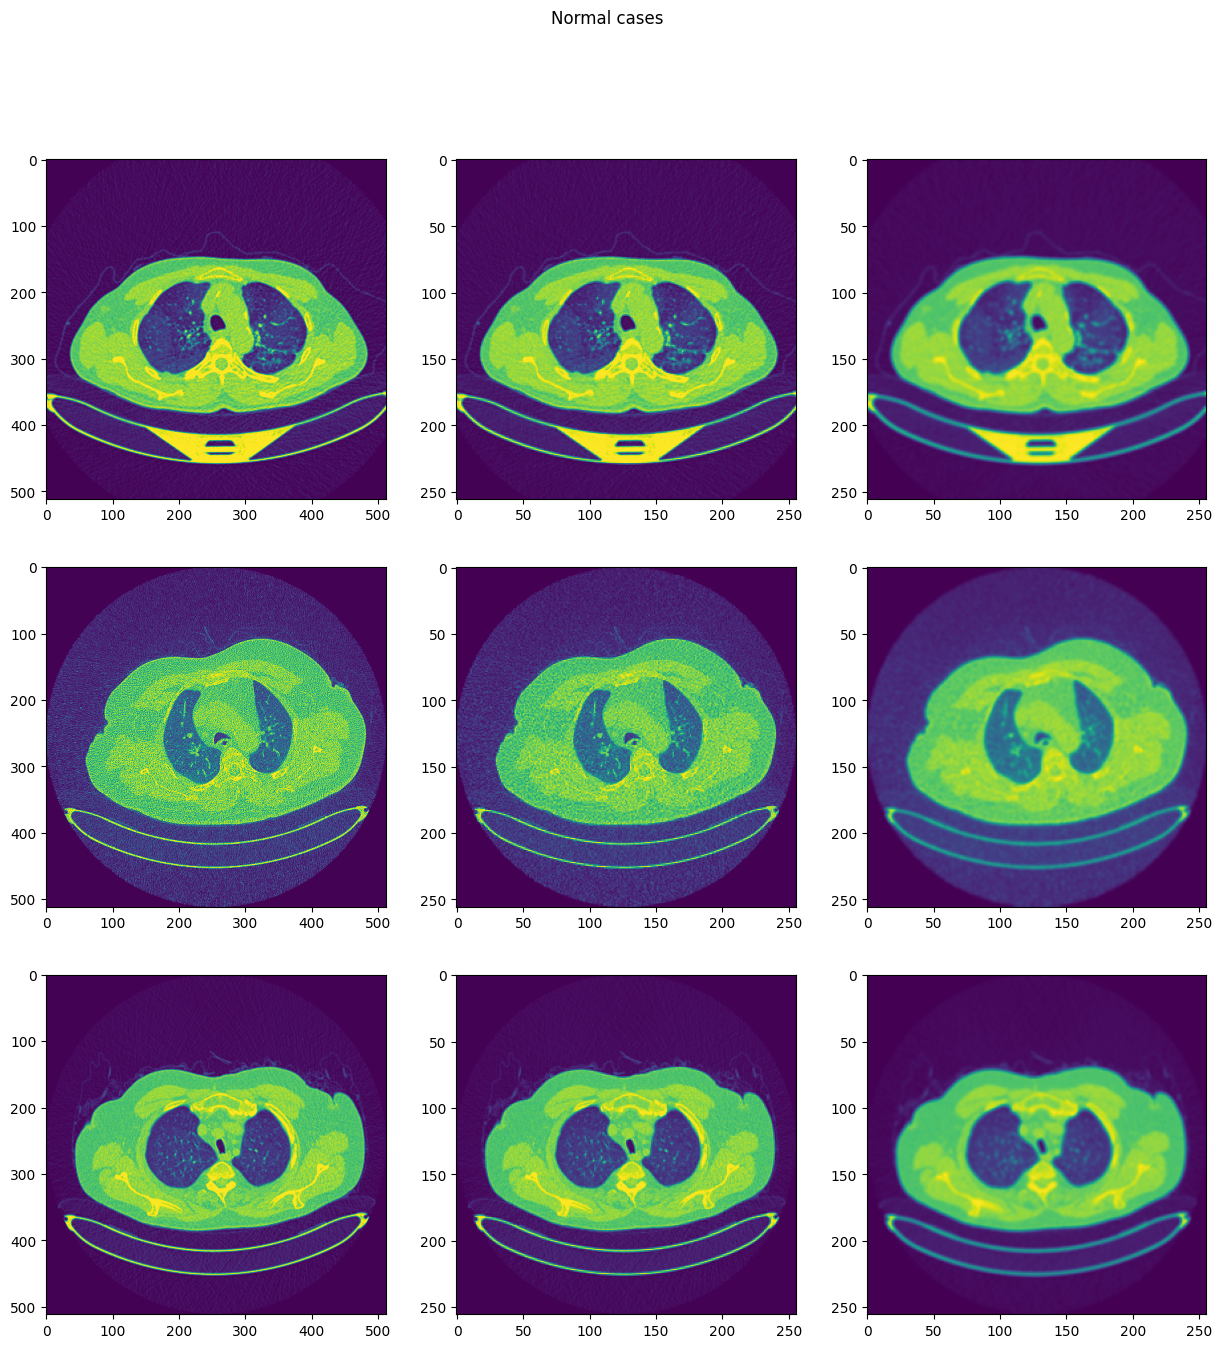

In [25]:

img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

The below code helps to do the following steps on the data:

Data Collection: The code collects image data from different categories (directories) and resizes them to a uniform size.

Data Preparation: It shuffles the collected data and organizes it into feature (image data) and label arrays.

Data Normalization: The pixel values in the images are scaled to a range between 0 and 1 to aid in training machine learning models.

Data Structure: The image data is converted into NumPy arrays, and the labels are prepared for use in machine learning models. This code sets up the data for subsequent machine learning tasks.

In [27]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


**Applying SMOTE to oversample the data**

In [30]:
print(Counter(y_train), Counter(y_valid))


Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [31]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [32]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [33]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


**Model Building with SMOTE data**

In [34]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [35]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
158/158 [==============================] - 33s 204ms/step - loss: 0.6569 - accuracy: 0.8127 - val_loss: 0.1279 - val_accuracy: 0.9491
Epoch 2/10
158/158 [==============================] - 31s 197ms/step - loss: 0.0330 - accuracy: 0.9952 - val_loss: 0.0819 - val_accuracy: 0.9709
Epoch 3/10
158/158 [==============================] - 32s 204ms/step - loss: 0.0089 - accuracy: 0.9992 - val_loss: 0.2000 - val_accuracy: 0.9855
Epoch 4/10
158/158 [==============================] - 33s 209ms/step - loss: 0.0320 - accuracy: 0.9960 - val_loss: 0.0669 - val_accuracy: 0.9709
Epoch 5/10
158/158 [==============================] - 33s 210ms/step - loss: 0.0170 - accuracy: 0.9968 - val_loss: 0.1434 - val_accuracy: 0.9636
Epoch 6/10
158/158 [==============================] - 36s 230ms/step - loss: 0.0198 - accuracy: 0.9960 - val_loss: 0.0372 - val_accuracy: 0.9891
Epoch 7/10
158/158 [==============================] - 34s 216ms/step - loss: 0.1393 - accuracy: 0.9802 - val_loss: 0.1169 - val_ac

**Results**

In [37]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 4s 400ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.99      1.00      0.99       141
           2       0.99      0.98      0.99       104

    accuracy                           0.99       275
   macro avg       0.99      0.98      0.99       275
weighted avg       0.99      0.99      0.99       275

[[ 29   0   1]
 [  0 141   0]
 [  0   2 102]]


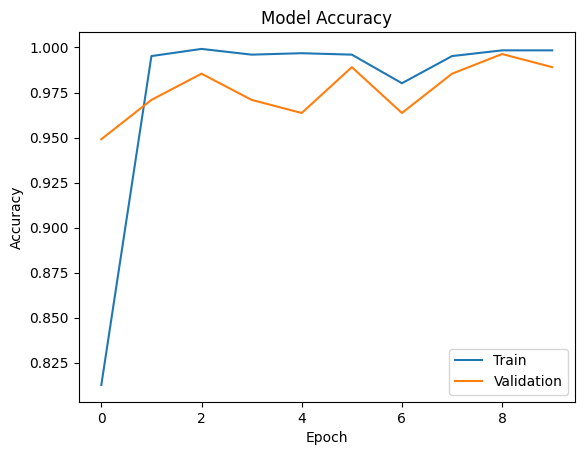

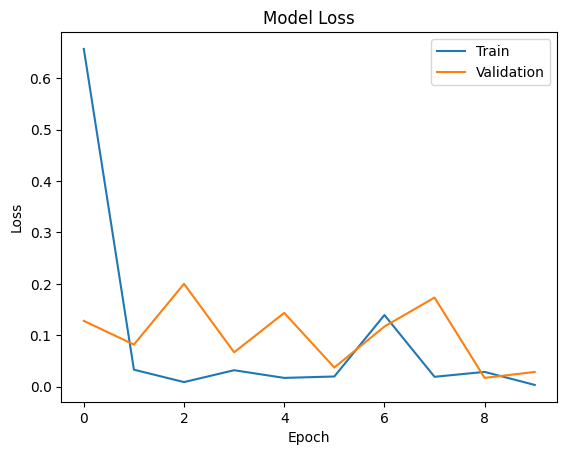

In [38]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [39]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_1 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 246016)           

In [40]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [42]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/10
103/103 [==============================] - 32s 309ms/step - loss: 0.9931 - accuracy: 0.6946 - val_loss: 0.2567 - val_accuracy: 0.9018
Epoch 2/10
103/103 [==============================] - 22s 215ms/step - loss: 0.0947 - accuracy: 0.9720 - val_loss: 0.0908 - val_accuracy: 0.9564
Epoch 3/10
103/103 [==============================] - 21s 203ms/step - loss: 0.0690 - accuracy: 0.9903 - val_loss: 0.1221 - val_accuracy: 0.9745
Epoch 4/10
103/103 [==============================] - 22s 210ms/step - loss: 0.0209 - accuracy: 0.9988 - val_loss: 0.0582 - val_accuracy: 0.9782
Epoch 5/10
103/103 [==============================] - 22s 212ms/step - loss: 0.0568 - accuracy: 0.9927 - val_loss: 0.1768 - val_accuracy: 0.9782
Epoch 6/10
103/103 [==============================] - 23s 227ms/step - loss: 0.0198 - accuracy: 0.9976 - val_loss: 0.0563 - val_accuracy: 0.9818
Epoch 7/10
103/103 [==============================] - 23s 224ms/step - loss: 0.0267 - accuracy: 0.9951 - val_loss: 0.0655 - val_ac

In [43]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 2s 223ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.99      0.99      0.99       141
           2       0.96      0.98      0.97       104

    accuracy                           0.98       275
   macro avg       0.97      0.96      0.97       275
weighted avg       0.98      0.98      0.98       275

[[ 27   0   3]
 [  0 140   1]
 [  1   1 102]]


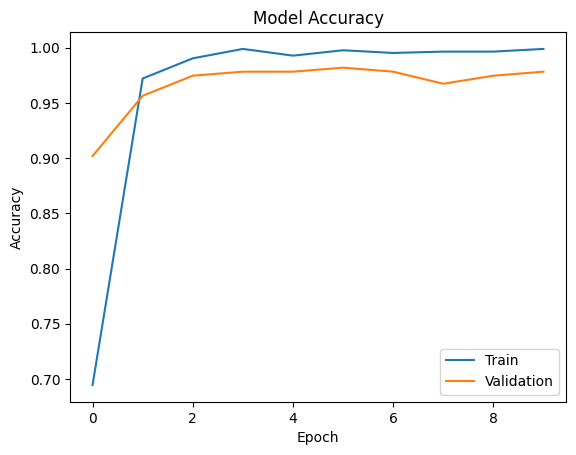

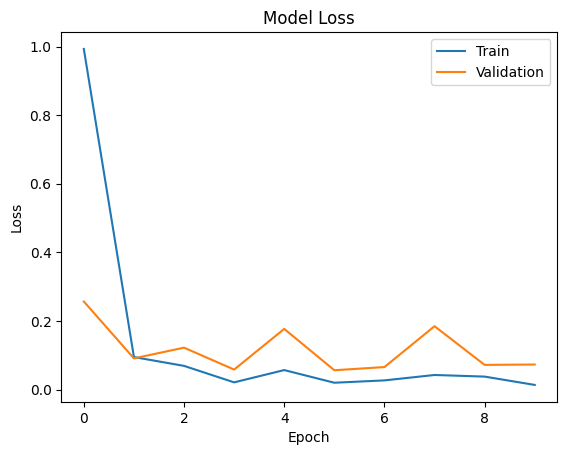

In [44]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [45]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) 
val_datagen = ImageDataGenerator()

In [46]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8) 
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [47]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_2 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 246016)           

In [48]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)

Epoch 1/5


/var/folders/6r/w6lhlth93yn4c397t0sc0gpw0000gn/T/ipykernel_59944/2485142853.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)


103/103 [==============================] - 23s 219ms/step - loss: 1.3306 - accuracy: 0.5134 - val_loss: 0.8949 - val_accuracy: 0.6145
Epoch 2/5
103/103 [==============================] - 21s 204ms/step - loss: 0.6993 - accuracy: 0.6910 - val_loss: 0.5838 - val_accuracy: 0.7709
Epoch 3/5
103/103 [==============================] - 22s 212ms/step - loss: 0.4834 - accuracy: 0.8200 - val_loss: 0.3679 - val_accuracy: 0.8582
Epoch 4/5
103/103 [==============================] - 22s 217ms/step - loss: 0.3444 - accuracy: 0.8783 - val_loss: 0.3723 - val_accuracy: 0.8364
Epoch 5/5
103/103 [==============================] - 23s 223ms/step - loss: 0.2191 - accuracy: 0.9246 - val_loss: 0.2042 - val_accuracy: 0.9309


In [50]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))


9/9 [==============================] - 3s 319ms/step
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        30
           1       0.99      0.91      0.95       141
           2       0.92      0.94      0.93       104

    accuracy                           0.93       275
   macro avg       0.89      0.94      0.91       275
weighted avg       0.94      0.93      0.93       275

[[ 29   0   1]
 [  4 129   8]
 [  5   1  98]]
